In [35]:
# !pip install pandas
# !pip install numpy
# !pip install seaborn
# !pip install matplotlib
# !pip install xgboost
# !pip install lightgbm
# !pip install sklearn

# 라이브러리 임포트
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import DataLoader, Dataset

import xgboost
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, RidgeCV, RidgeClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV

import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix

import os
import json
import numpy as np
import pandas as pd
from attrdict import AttrDict
from transformers import (
    BertTokenizer,
    ElectraTokenizer,
)
from transformers import pipeline, utils, ElectraForSequenceClassification
from bertviz import model_view

import warnings
warnings.filterwarnings('ignore')

In [5]:
Model = {
    'ElectraForSequenceClassification' : ElectraForSequenceClassification,
    
}

Tokenizer ={
    "BertTokenizer": BertTokenizer,
    "ElectraTokenizer": ElectraTokenizer,
}

In [6]:
config_path = os.path.join('/USER/Comment/exp_config/config.json')

def set_config(config_path):
    if os.path.lexists(config_path):
        with open(config_path) as f:
            args = AttrDict(json.load(f))
            print("config file loaded.")
            print(args.pretrained_model)
    else:
        assert False, 'config json file cannot be found.. please check the path again.'
    
    return args


# 코드 중간중간에 끼워넣어 리셋 가능
args = set_config(config_path)

config file loaded.
beomi/KcELECTRA-base


In [9]:
df = pd.read_csv('/USER/Comment/data/train.csv')

In [ ]:
df = combine(df, 'emp_length', 12)

In [ ]:
df = combine(df, 'home_ownership', 6)

In [ ]:
df = combine(df, 'verification_status', 3)

In [ ]:
df = combine(df, 'purpose', 14)

In [ ]:
df = combine(df, 'initial_list_status', 2)

In [ ]:
df = combine(df, 'mths_since_last_delinq', 11)

In [5]:
df = combine(df, 'emp_length', 12)
df = combine(df, 'home_ownership', 6)
df = combine(df, 'verification_status', 3)
df = combine(df, 'purpose', 14)
df = combine(df, 'initial_list_status', 2)
df = combine(df, 'mths_since_last_delinq', 11)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 34 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   int_rate                    100000 non-null  float64
 1   annual_inc                  100000 non-null  float64
 2   dti                         100000 non-null  float64
 3   delinq_2yrs                 100000 non-null  int64  
 4   inq_last_6mths              100000 non-null  int64  
 5   pub_rec                     100000 non-null  int64  
 6   revol_bal                   100000 non-null  int64  
 7   total_acc                   100000 non-null  int64  
 8   collections_12_mths_ex_med  100000 non-null  int64  
 9   acc_now_delinq              100000 non-null  int64  
 10  tot_coll_amt                100000 non-null  int64  
 11  tot_cur_bal                 100000 non-null  int64  
 12  chargeoff_within_12_mths    100000 non-null  int64  
 13  delinq_amnt    

In [ ]:
df['emp_length']

0         0
1         1
2         3
3         2
4         3
         ..
99995     6
99996    10
99997     3
99998    11
99999     4
Name: emp_length, Length: 100000, dtype: int64

# Custom Dataset

In [40]:
class dataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.model = Model[args.architecture].from_pretrained(args.pretrained_model, output_attentions=True, output_hidden_states=True)
        self.tokenizer = Tokenizer[args.tokenizer_class].from_pretrained(args.pretrained_model)
        
        self.hate = {
            'none' : 0,
            'hate' : 1
        }
        self.bias ={
            'none' : 0,
            'others' : 1,
            'gender' :2
        }
        
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, index):
        x =  self.data.iloc[index]
        hate_label = x['hate']
        bias_label = x['bias']
        
        inputs = self.tokenizer.encode(x['comment'], return_tensors='pt')  # Tokenize input text
        outputs = self.model(inputs)
        hiddens = outputs.hidden_states
        
        para = self.getPara(hiddens)
        
        return para, int(self.hate [hate_label]), int(self.bias[bias_label])
    
    def getPara(self, hiddens):
        a = torch.zeros(hiddens[0].size())
        
        for hidden in hiddens:
            a += hidden.squeeze(0)

        b = a.squeeze(0)
        c = torch.zeros(a.squeeze(0)[0].size())

        l = len(c)

        for i in b:
            c += i
            
        return c/l
        
     

In [11]:
# data를 training set과 validation set으로 나누기
X_train, X_valid = train_test_split(df, test_size=0.2)

In [25]:
X_train.info()
X_train.iloc[1]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6693 entries, 5322 to 4739
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    6693 non-null   object
 1   comment  6693 non-null   object
 2   bias     6693 non-null   object
 3   hate     6693 non-null   object
dtypes: object(4)
memory usage: 261.4+ KB


title      "[종합]""23년 만에 주연""…'천화' 이일화, 덕선 엄마의 과감한 변신"
comment                              지금도 남심 녹이기 충분하십니다
bias                                              none
hate                                              none
Name: 1913, dtype: object

In [14]:
X_valid.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1674 entries, 5603 to 4551
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    1674 non-null   object
 1   comment  1674 non-null   object
 2   bias     1674 non-null   object
 3   hate     1674 non-null   object
dtypes: object(4)
memory usage: 65.4+ KB


In [41]:
train_dataset = dataset(X_train)
validation_dataset = dataset(X_valid)
train_dataloader = DataLoader(train_dataset, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, shuffle=True)

Some weights of the model checkpoint at beomi/KcELECTRA-base were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.de

In [42]:
cnt = 0
for l,k,m in train_dataloader:
    if cnt == 1: 
        break
    cnt += 1
    print(l, k , m)


tensor([[-2.5526e-02, -1.1313e-02,  7.2495e-02,  1.8531e-02, -1.7623e-02,
          3.2245e-02,  3.7366e-03, -1.5395e-02, -2.2800e-02,  5.7469e-03,
         -1.6124e-02, -1.2062e-02, -1.5900e-02,  8.2430e-03, -4.8010e-04,
         -8.3596e-03,  7.3531e-04, -8.0289e-03, -1.0935e-02,  2.4089e-02,
          2.0936e-02, -1.6866e-02,  1.4925e-03,  3.0910e-02,  1.8870e-02,
          1.1984e-02, -1.1399e-02, -1.1627e-03, -1.8630e-03,  3.9286e-02,
         -4.4649e-03, -4.2046e-03,  4.1514e-03, -8.1709e-03,  2.5516e-03,
          8.6989e-03, -5.5057e-03, -1.8353e-02, -9.5003e-03, -1.9340e-03,
          1.0853e-02,  2.1031e-02,  2.1646e-02,  2.9215e-02, -1.4559e-03,
         -1.4830e-03,  1.2512e-02, -1.3605e-02,  1.1411e-02,  1.3899e-02,
          2.0430e-01,  1.1479e-02,  9.6186e-03,  2.7583e-03, -1.9407e-02,
          2.6170e-02,  9.6895e-03, -9.5837e-03, -9.8935e-03,  4.7644e-03,
         -2.8151e-02,  2.5367e-03,  3.5049e-03,  2.4695e-02,  7.4444e-03,
         -9.4234e-03,  9.5686e-03,  5.

In [104]:
new_data = pd.DataFrame()
bias_data = pd.DataFrame()
hate_data = pd.DataFrame()

In [105]:
cnt = 0
for l,k,m in train_dataloader:
    if cnt == 1: 
        break
    cnt += 1
    # print(l, k , m)
    l = l.squeeze(0)
    df = pd.DataFrame(l.detach().numpy())
    hate_df = pd.DataFrame(k.detach().numpy())
    bias_df = pd.DataFrame(m.detach().numpy())
    new_data=df.transpose()
    bias_data = hate_df
    hate_data = bias_df
    

In [106]:
new_data.drop(0)
bias_data.drop(0)
hate_data.drop(0)

,0


In [107]:
from tqdm import tqdm
for l,k,m in tqdm(train_dataloader):
    l = l.squeeze(0)
    df = pd.DataFrame(l.detach().numpy())
    hate_df = pd.DataFrame(k.detach().numpy())
    bias_df = pd.DataFrame(m.detach().numpy())
    new_data = new_data.append(df.transpose())
    bias_data = bias_data.append(bias_df)
    hate_data = hate_data.append(hate_df)

100% 6693/6693 [3:31:05<00:00,  1.89s/it]  


In [117]:
# new_data.to_csv('./train.csv')
# bias_data.to_csv('./train_bias.csv')
# hate_data.to_csv('./train_hate.csv')

In [108]:
val_data = pd.DataFrame()
val_bias_data = pd.DataFrame()
val_hate_data = pd.DataFrame()

In [109]:
  
cnt = 0
for l,k,m in train_dataloader:
    if cnt == 1: 
        break
    cnt += 1
    # print(l, k , m)
    l = l.squeeze(0)
    df = pd.DataFrame(l.detach().numpy())
    hate_df = pd.DataFrame(k.detach().numpy())
    bias_df = pd.DataFrame(m.detach().numpy())
    val_data=df.transpose()
    val_hate_data = hate_df
    val_bias_data = bias_df


In [110]:
val_data.drop(0)
val_bias_data.drop(0)
val_hate_data.drop(0)

,0


In [111]:
val_data.drop(0)
from tqdm import tqdm
for l,k,m in tqdm(validation_dataloader):
    l = l.squeeze(0)
    df = pd.DataFrame(l.detach().numpy())
    hate_df = pd.DataFrame(k.detach().numpy())
    bias_df = pd.DataFrame(m.detach().numpy())
    val_data = val_data.append(df.transpose())
    val_bias_data = val_bias_data.append(bias_df)
    val_hate_data = val_hate_data.append(hate_df)

100% 1674/1674 [51:23<00:00,  1.84s/it] 


In [133]:
val_data.to_csv('./val_data.csv')
val_bias_data.to_csv('./val_bias.csv')
val_hate_data.to_csv('./val_hate.csv')

In [8]:
# training set과 validation set의 데이터 수 확인
print('training set length :', len(X_train))
print('validation set length :', len(X_valid))

training set length : 80000
validation set length : 20000


In [ ]:
# validation set의 라벨 비율 확인
y_valid.sum()/len(y_valid)

0.32445

`# Single Model(XGBoost)
## XGBClassifier의 하이퍼 파라미터 설명
- **LINK** : https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier
- **max_depth=3** : 디시전 트리의 최대 깊이
- **learning_rate=0.1** : 0과 1 사이의 값을 가지는 부스팅에 대한 학습률(eta). 매 부스팅 단계 이후 새로이 추가된 가중치는 이 파라미터로 조정된다. 이 값이 낮을수록 보수적이며, 수렴에 필요한 더 많은 디시전 트리가 필요하다.
- **n_estimators=100** : 라운드의 횟수 또는 부스팅된 디시전 트리의 개수
- **silent=True** : 부스팅의 수행 동안 메시지를 출력할지에 대한 여부
- **objective="reg:linear"** : 모델이 학습할 작업의 분류, 미리 정의된 작업은 문자열로 지정이 가능하지만, 그렇지 않은 경우 콜러블callable을 만들어서 지정할 수도 있다.
- **booster="gbtree"** : 'gbtree', 'gblinear', 'dart'일 수 있다. 'dart'는 드롭아웃(dropout)이라는 특성을 추가한다(과적합 방지를 위해 무작위로 디시전 트리를 선택해 제거(드롭)한다). 'gblinear'는 정규화된 선형 모델을 만든다(디시전 트리가 아니라 라소 회귀와 유사하다).
- **nthread=None** : 더 이상 사용되지 않는다.
- **n_jobs** : 사용할 스레드의 개수
- **gamma=0** : 노드 분할에 필요한 최소 손실 감소
- **min_child_weight=1** : 자식 노드 생성에 필요한 헤시안(hessian) 합의 최솟값
- **max_delta_step=0** : 보다 보수적으로 갱신을 수행하도록 만드는 값. 불균형 범주의 데이터셋에 대해서는 1부터 10까지의 값으로 설정한다.
- **subsample=1** : 부스팅에 사용할 샘플의 비율
- **colsample_bytree=1** : 부스팅에 사용할 특징 열의 비율
- **colsample_bylevel=1** : 각 디시전 트리의 수준별 사용할 특징 열의 비율
- **colsample_bynode=1** : 각 디시전 트리의 노드별 사용할 특징 열의 비율
- **reg_alpha=0** : L1 정규화(가중치의 평균). 이 값이 클수록 보수적이게 된다.
- **reg_lambda=1** : L2 정규화(가중치의 제곱근). 이 값이 클수록 보수적이게 된다.
- **base_score=.5** : 초기 편향치(bias)
- **seed=None** : 더 이상 사용되지 않는다.
- **random_state=0** : 난수 생성 시드
- **missing=None** : 누락된 데이터가 해석될 값. None은 np.nan을 의미한다.
- **importance_type='gain'** : 특징 중요도의 유형. 'gain', 'weight', 'cover', 'total_gain', 'total_cover'로 설정될 수 있다.

In [ ]:
# 하이퍼 파라미터 튜닝
xgb_clf = xgboost.XGBClassifier()

param_grid = {'max_depth':[3, 10],
              'learning_rate':[0.1, 0.05],
              'n_estimators':[100, 500],
              'colsample_bytree': [0.5, 0,75],
              'min_child_weight' : [1, 3]}

cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=2)

grid_search = GridSearchCV(estimator=xgb_clf,
                           param_grid=param_grid, 
                           n_jobs=-1,
                           cv=cv,
                           scoring='f1', #이부분을 F1 SCORE로 바꾸어 볼 수 있다. 
                           error_score=0) 

results=grid_search.fit(X_train, y_train)

results.best_params_

KeyboardInterrupt: ignored

## hate clssification

In [135]:
# best parameter를 사용하여 prediction 수행
xgb_clf_hate = xgboost.XGBClassifier(max_depth = 7,
                                n_estimators =500,
                                colsample_bytree= 0.5,
                                min_child_weight = 3,
                                reg_alpha = 0.03,
                                learning_rate=0.05,
                                objective = 'binary:logistic',
                                eval_metric='mlogloss')

xgb_clf_hate.fit(new_data, hate_data)


y_pred_hate = xgb_clf_hate.predict(val_data)

NotFittedError: need to call fit or load_model beforehand

In [136]:
y_pred_hate = xgb_clf_hate.predict(val_data)

In [113]:
# y_valid가 0 또는 1일 확률 출력
y_pred_prob = xgb_clf.predict_proba(val_data)


print(len(y_pred_prob))
y_pred_prob

1675


array([[0.97928625, 0.02071377],
       [0.18774039, 0.8122596 ],
       [0.5207901 , 0.47920993],
       ...,
       [0.99466306, 0.00533692],
       [0.02521306, 0.97478694],
       [0.79827935, 0.20172065]], dtype=float32)

In [ ]:
# y_valid가 1일 확률 출력
y_pred_prob[:,1]

array([0.54131407, 0.12233078, 0.24639614, ..., 0.15840751, 0.03906867,
       0.17314816], dtype=float32)

In [ ]:

# y_valid 예측값 출력
# y_pred_prob[:,1]이 0.5(threshold)보다 큰 경우 1의 예측값을 return한다

print(len(y_pred_xgb))
y_pred_xgb

20000


array([1, 0, 0, ..., 0, 0, 0])

In [ ]:

# 1로 예측된 y_valid 갯수 및 비율 출력
print(y_pred_xgb.sum())
print(y_pred_xgb.sum()/len(y_pred_xgb))

4632
0.2316


In [139]:
# 평가 함수 정의
def get_clf_eval(y_actual, y_pred):
    accuracy = accuracy_score(y_actual, y_pred)
    # precision = precision_score(y_actual, y_pred)
    # recall = recall_score(y_actual, y_pred)
    # AUC = roc_auc_score(y_actual, y_pred)
    # F1 = f1_score(y_actual, y_pred)
    print('\n정확도: {:.4f}'.format(accuracy))
    # print('정밀도: {:.4f}'.format(precision))
    # print('재현율: {:.4f}'.format(recall))
    # print('AUC: {:.4f}'.format(AUC))
    # print('F1: {:.4f}'.format(F1))
    
    sns.heatmap(confusion_matrix(y_actual, y_pred), annot=True, fmt='d', cmap='YlGnBu')


정확도: 0.7839
정밀도: 0.7829
재현율: 0.8452
AUC: 0.7763
F1: 0.8128


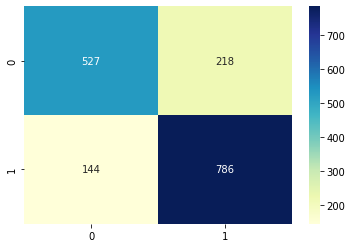

In [138]:
# xgboost 성능 확인
get_clf_eval(val_hate_data, y_pred_hate)
#재현율을 높히는 방향으로 threshold를 조정하는 것도 좋다.


정확도: 0.7821
정밀도: 0.7604
재현율: 0.8871
AUC: 0.7691
F1: 0.8189


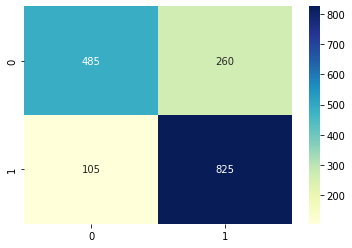

In [121]:
# threshold 변경 및 성능 확인
get_clf_eval(val_hate_data, y_pred_prob[:,1]>0.4)

object를 이진으로 바꾸고 난 뒤 결과
> 확인 결과 똑같다. 

## bias classification

In [142]:
# best parameter를 사용하여 prediction 수행
xgb_clf = xgboost.XGBClassifier(max_depth = 7,
                                n_estimators =500,
                                colsample_bytree= 0.5,
                                min_child_weight = 3,
                                reg_alpha = 0.03,
                                learning_rate=0.05,
                                eval_metric='mlogloss')

xgb_clf.fit(new_data, bias_data)


y_pred_xgb = xgb_clf.predict(val_data)

In [141]:
y_pred_xgb = xgb_clf.predict(val_data)

NotFittedError: need to call fit or load_model beforehand


정확도: 0.7576


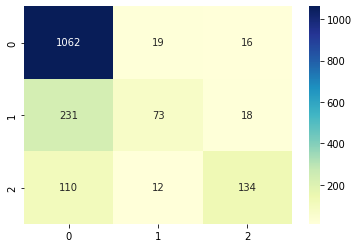

In [143]:
get_clf_eval(val_bias_data, y_pred_xgb)

# Ensemble(Voting)

In [ ]:
rnd_clf = RandomForestClassifier()
lgbm_clf = LGBMClassifier(max_depth = 7,
                                n_estimators =500,
                                colsample_bytree= 0.5,
                                min_child_weight = 3,
                                reg_alpha = 0.3,
                                reg_lambda = 0.05,
                                learning_rate=0.05,
                                application = 'binary',
                                eval_metric='mlogloss')
# rid_clf = RidgeClassifier()
# dtc_clf = DecisionTreeClassifier()
# svm_clf = SVC()
# ada_clf = AdaBoostClassifier()
# gbc_clf = GradientBoostingClassifier()
# bag_clf = BaggingClassifier()
# ext_clf = ExtraTreesClassifier()
# knn_clf = KNeighborsClassifier()
# svc_clf = SVC()
#tree 기반 모델은 scaling을 할 필요 없지만 -> 다른 딥러닝이나 이런걸 사용하게 되면 min-max scaling등을 활용해야 될 수도 있다. 

voting_clf = VotingClassifier(estimators=[('rnd', rnd_clf), ('lgbm', lgbm_clf), ('xgb', xgb_clf)], voting='soft')


정확도: 0.7542
정밀도: 0.6767
재현율: 0.4656
AUC: 0.6793
F1: 0.5516


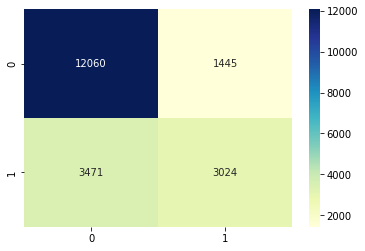

In [ ]:
for clf in (rnd_clf, lgbm_clf, xgb_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred_vote = clf.predict(X_valid)

# ensemble(voting) 성능 확인
get_clf_eval(y_valid, y_pred_vote)

# Ensemble(Stacking)

### 튜닝된 xgboost와 튜닝이 안된 random forest, lgbm을 stacking



정확도: 0.7549
정밀도: 0.6676
재현율: 0.5090
AUC: 0.6923
F1: 0.5776


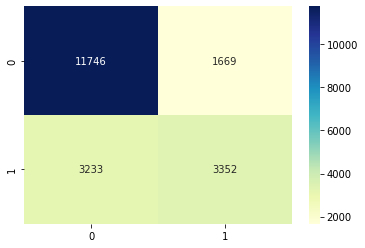

In [ ]:
stacking_clf = StackingClassifier(estimators=[('rnd', rnd_clf), ('lgbm', lgbm_clf), ('xgb', xgb_clf)], final_estimator = LGBMClassifier())
stacking_clf.fit(X_train, y_train)
y_pred_stack = stacking_clf.predict(X_valid)

# ensemble(stacking) 성능 확인
get_clf_eval(y_valid, y_pred_stack)

In [ ]:
y_prob = stacking_clf.predict_proba(X_valid)

In [ ]:
y_prob

array([[0.94509169, 0.05490831],
       [0.60311312, 0.39688688],
       [0.8737651 , 0.1262349 ],
       ...,
       [0.23401615, 0.76598385],
       [0.6192799 , 0.3807201 ],
       [0.96740097, 0.03259903]])


정확도: 0.7442
정밀도: 0.5992
재현율: 0.6740
AUC: 0.7264
F1: 0.6344


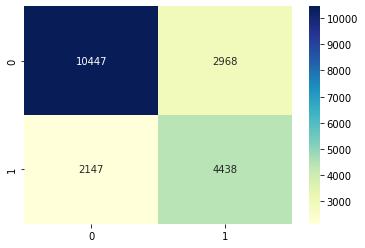

In [ ]:
get_clf_eval(y_valid, y_prob[:,1]>0.4)

### 마지막 판단을 xgboost로 변경
앞선 lgbm보다 속도가 더 걸리는 경향이 있다.
f1 score는 올랐으나, public 점수는 더 떨어진 것을 알 수 있다.


정확도: 0.7552
정밀도: 0.6624
재현율: 0.5232
AUC: 0.6961
F1: 0.5846


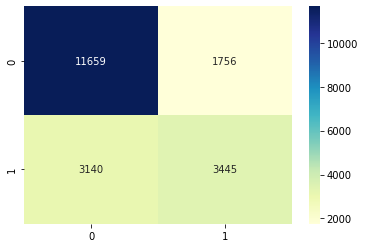

In [ ]:
stacking_clf = StackingClassifier(estimators=[('rnd', rnd_clf), ('lgbm', lgbm_clf), ('xgb', xgb_clf)], final_estimator = XGBClassifier())
stacking_clf.fit(X_train, y_train)
y_pred_stack = stacking_clf.predict(X_valid)

# ensemble(stacking) 성능 확인
get_clf_eval(y_valid, y_pred_stack)


정확도: 0.7460
정밀도: 0.6028
재현율: 0.6702
AUC: 0.7267
F1: 0.6347


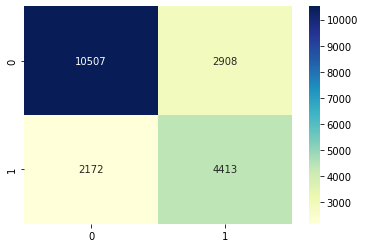

In [ ]:
y_prob = stacking_clf.predict_proba(X_valid)
get_clf_eval(y_valid, y_prob[:,1]>0.4)

### lgbm 튜닝후 


정확도: 0.7557
정밀도: 0.6645
재현율: 0.5209
AUC: 0.6959
F1: 0.5840


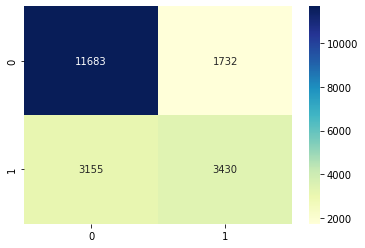

In [ ]:
stacking_clf = StackingClassifier(estimators=[('rnd', rnd_clf), ('lgbm', lgbm_clf), ('xgb', xgb_clf)], final_estimator = LGBMClassifier())
stacking_clf.fit(X_train, y_train)
y_pred_stack = stacking_clf.predict(X_valid)

# ensemble(stacking) 성능 확인
get_clf_eval(y_valid, y_pred_stack)


정확도: 0.7452
정밀도: 0.6009
재현율: 0.6737
AUC: 0.7270
F1: 0.6352


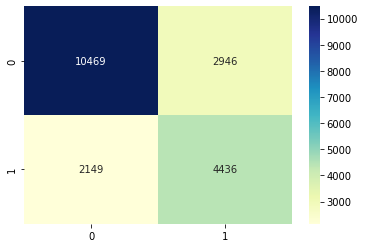

In [ ]:
y_prob = stacking_clf.predict_proba(X_valid)
get_clf_eval(y_valid, y_prob[:,1]>0.4)

# Submission

In [147]:
test_df = pd.read_csv('/USER/Comment/data/test.csv')

In [145]:
class test_dataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.model = Model[args.architecture].from_pretrained(args.pretrained_model, output_attentions=True, output_hidden_states=True)
        self.tokenizer = Tokenizer[args.tokenizer_class].from_pretrained(args.pretrained_model)

        
    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, index):
        x =  self.data.iloc[index]
        inputs = self.tokenizer.encode(x['comment'], return_tensors='pt')  # Tokenize input text
        outputs = self.model(inputs)
        hiddens = outputs.hidden_states
        
        para = self.getPara(hiddens)
        
        return para
    
    def getPara(self, hiddens):
        a = torch.zeros(hiddens[0].size())
        
        for hidden in hiddens:
            a += hidden.squeeze(0)

        b = a.squeeze(0)
        c = torch.zeros(a.squeeze(0)[0].size())

        l = len(c)

        for i in b:
            c += i
            
        return c/l
        

In [148]:
test_dataset = test_dataset(test_df)
test_dataloader = DataLoader(test_dataset)

Some weights of the model checkpoint at beomi/KcELECTRA-base were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base and are newly initialized: ['classifier.dense.bias', 'classifier.de

In [167]:
test_data = pd.DataFrame()    
cnt = 0
for l in test_dataloader:
    if cnt == 1: 
        break
    cnt += 1
    # print(l, k , m)
    print(type(l))
    # l = l.squeeze(0)
    df = pd.DataFrame(l.detach().numpy())
    print(df)
    test_data=df
    
test_data.drop(0)

from tqdm import tqdm
for l in tqdm(test_dataloader):
    df = pd.DataFrame(l.detach().numpy())
    test_data = test_data.append(df)

test_data.to_csv('./test_test.csv')

<class 'torch.Tensor'>
        0         1         2         3         4         5         6    \
0 -0.014718  0.000084  0.037259 -0.009538 -0.010286  0.046514  0.000419   

        7         8        9    ...       758       759       760       761  \
0  0.024895 -0.020383  0.00812  ...  0.012841  0.025288  0.012872  0.000755   

        762       763       764       765       766       767  
0  0.004996  0.038253 -0.021419  0.033071 -0.026595 -0.013437  

[1 rows x 768 columns]


100% 511/511 [19:50<00:00,  2.33s/it]


In [168]:
test_data


,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.014718,0.000084,0.037259,-0.009538,-0.010286,0.046514,0.000419,0.024895,-0.020383,0.008120,...,0.012841,0.025288,0.012872,0.000755,0.004996,0.038253,-0.021419,0.033071,-0.026595,-0.013437
0,-0.014718,0.000084,0.037259,-0.009538,-0.010286,0.046514,0.000419,0.024895,-0.020383,0.008120,...,0.012841,0.025288,0.012872,0.000755,0.004996,0.038253,-0.021419,0.033071,-0.026595,-0.013437
0,-0.011426,0.013087,0.054974,-0.040423,0.013366,-0.001121,-0.037517,-0.002282,0.021942,0.014186,...,0.010654,-0.026776,-0.008936,-0.065058,-0.034566,0.012947,0.018438,-0.009513,-0.014315,-0.017394
0,-0.012587,-0.001025,0.040860,0.007444,-0.021712,0.016394,0.003261,-0.010516,-0.009509,0.004389,...,-0.003787,-0.018238,-0.006872,0.000151,-0.007259,0.001539,-0.019134,0.006809,-0.007543,-0.006051
0,-0.023395,-0.120544,0.082707,0.048467,-0.074245,-0.045593,-0.052607,0.020947,0.000874,-0.053226,...,0.014842,0.049897,0.005982,0.062714,0.014319,0.061816,-0.022981,0.012318,-0.047131,-0.016340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,-0.036476,-0.019784,0.079633,0.005463,-0.038353,-0.015377,0.006873,0.003107,-0.016032,0.003897,...,-0.024555,-0.057730,0.008112,-0.014338,-0.013621,0.022245,-0.042747,-0.032363,-0.017631,-0.006438
0,0.005038,-0.014012,0.117567,-0.005042,-0.048065,-0.012754,0.008376,0.054181,-0.046089,0.004606,...,-0.006926,0.049640,0.002140,0.008987,-0.050880,0.041566,-0.017408,0.019353,-0.030410,-0.016948
0,-0.020948,-0.068061,0.026074,-0.005287,-0.104153,-0.096524,-0.020223,-0.039062,-0.050065,0.027267,...,0.049971,0.014937,0.012499,-0.069453,0.067266,-0.007491,-0.014603,-0.061328,-0.011808,0.040134
0,-0.034497,-0.064999,0.153210,0.008763,-0.040898,-0.005101,-0.025360,-0.017292,-0.083481,0.053964,...,0.028707,0.121460,-0.010738,-0.089565,-0.019460,0.029170,0.035809,0.079346,-0.059209,-0.006568


In [169]:
y_pred_hate = xgb_clf_hate.predict(test_data)
y_pred_bias = xgb_clf.predict(test_data)

In [173]:
print(len(y_pred_hate),len(y_pred_bias) )

512 512


In [178]:
hate = {
    0:"none",
    1:'hate'
       }
bias = {
    0 : "none",
    1: "others",
    2 : "gender"
}

In [184]:
submit = pd.read_csv('/USER/Comment/data/sample_submission.csv')
for i in range(511):
    submit['bias'].iloc[i] = bias[y_pred_bias[1:][i]]
    submit['hate'].iloc[i] = hate[y_pred_hate[1:][i]]

In [185]:
print(submit)

# 제출 파일 저장
submit.to_csv('./pred.csv', index=False)

      ID    bias  hate
0      0    none  none
1      1    none  hate
2      2    none  hate
3      3  others  hate
4      4    none  none
..   ...     ...   ...
506  506    none  hate
507  507    none  none
508  508  gender  hate
509  509    none  hate
510  510    none  hate

[511 rows x 3 columns]


In [186]:
soong = pd.read_csv("/USER/Comment/Visualization/kcelectra klue_roberta kcelectra_soongsil bias_hate_따로.csv")

In [187]:
soong

,ID,bias,hate
0,0,none,none
1,1,none,none
2,2,none,hate
3,3,none,hate
4,4,others,hate
...,...,...,...
506,506,none,hate
507,507,none,none
508,508,others,hate
509,509,others,none


In [188]:
submit['bias'] = soong['bias']

In [189]:
submit

,ID,bias,hate
0,0,none,none
1,1,none,hate
2,2,none,hate
3,3,none,hate
4,4,others,none
...,...,...,...
506,506,none,hate
507,507,none,none
508,508,others,hate
509,509,others,hate


In [190]:
submit.to_csv('./pred2.csv', index=False)